In [1]:
!pip install yfinance pandas numpy matplotlib xgboost lightgbm scikit-learn seaborn
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Core
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import (
    TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, make_scorer
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)




# **Step 1: Install and Import Libraries**

# **Step 2: Download Historical Data**

Download daily S&P 500 data from Yahoo Finance (2010–2024):

In [2]:
# Download S&P 500 (^GSPC) data
data = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')

# Display the first few rows
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000


In [3]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [4]:
data.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   3773 non-null   float64
 1   (High, ^GSPC)    3773 non-null   float64
 2   (Low, ^GSPC)     3773 non-null   float64
 3   (Open, ^GSPC)    3773 non-null   float64
 4   (Volume, ^GSPC)  3773 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB


In [6]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,3773.000000,3773.000000,3773.000000,3773.000000,3.773000e+03
mean,2727.439112,2741.379794,2711.377890,2726.890928,3.938928e+09
std,1264.115621,1270.407956,1257.309511,1264.040211,9.514030e+08
min,1022.580017,1032.949951,1010.909973,1027.650024,0.000000e+00
25%,1701.839966,1707.630005,1693.290039,1699.859985,3.374490e+09
50%,2431.770020,2441.399902,2419.969971,2431.919922,3.784360e+09
75%,3818.800049,3843.669922,3789.540039,3816.219971,4.301060e+09
max,6090.270020,6099.970215,6079.979980,6089.029785,1.061781e+10


In [7]:
data.to_csv('sp500_data.csv')

# **Step 3: Feature Engineering**

Create log returns, rolling averages, and the target (volatility).

In [8]:
# Calculate daily log returns
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

# Rolling statistics
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()

# Realized volatility as target (standard deviation of log returns over 10 days)
data['RealizedVolatility'] = data['LogReturn'].rolling(window=10).std()

# Drop missing rows
data = data.dropna()

data.head()

Price,Close,High,Low,Open,Volume,LogReturn,MA_5,MA_20,Volume_MA_5,RealizedVolatility
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,
Date,,,,,,,,,,
2010-02-01,1089.189941,1089.380005,1073.890015,1073.890015,4077610000,0.014165,1087.452002,1121.862000,4.998778e+09,0.012735
2010-02-02,1103.319946,1104.729980,1087.959961,1090.050049,4749540000,0.012890,1089.681982,1120.378497,5.002304e+09,0.012804
2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4285450000,-0.005489,1089.637988,1118.416498,4.795570e+09,0.012616
2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5859690000,-0.031636,1085.353979,1114.714996,4.877028e+09,0.014759
2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6438900000,0.002893,1083.817969,1110.939996,5.082238e+09,0.013546


# **Step 4: Define Regression Features and Target**

Now that you have engineered features, define:

X (independent variables) → predictors

y (dependent variable) → realized volatility

In [9]:
# Feature columns
features = ['LogReturn', 'MA_5', 'MA_20', 'Volume', 'Volume_MA_5']

# Target variable
target = 'RealizedVolatility'

X = data[features]
y = data[target]

print(X.shape, y.shape)


(3754, 5) (3754,)


# **Create a binary classification label from RealizedVolatility**

In [10]:
# Use median split (balanced) — change to quantile(0.7) for top-30%-as-high, etc.
threshold = data['RealizedVolatility'].median()
data['VolHigh'] = (data['RealizedVolatility'] >= threshold).astype(int)

features = ['LogReturn', 'MA_5', 'MA_20', 'Volume', 'Volume_MA_5']
X = data[features].copy()
y_cls = data['VolHigh'].copy()

print("Threshold used for High volatility:", threshold)
y_cls.value_counts(normalize=True).rename({0:'Low',1:'High'}).to_frame('share')


Threshold used for High volatility: 0.007523539859444759


,share
VolHigh,
High,0.5
Low,0.5


# **Train Test Split**

In [11]:
split_idx = int(len(X) * 0.80)  # 80% train, 20% test chronologically
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (3003, 5) Test size: (751, 5)


In [12]:
X_train

Price,LogReturn,MA_5,MA_20,Volume,Volume_MA_5
Ticker,,,,^GSPC,
Date,,,,,
2010-02-01,0.014165,1087.452002,1121.862000,4077610000,4.998778e+09
2010-02-02,0.012890,1089.681982,1120.378497,4749540000,5.002304e+09
2010-02-03,-0.005489,1089.637988,1118.416498,4285450000,4.795570e+09
2010-02-04,-0.031636,1085.353979,1114.714996,5859690000,4.877028e+09
2010-02-05,0.002893,1083.817969,1110.939996,6438900000,5.082238e+09
...,...,...,...,...,...
2021-12-28,-0.001011,4729.824023,4653.701538,2707920000,3.156658e+09
2021-12-29,0.001401,4758.590039,4665.004541,2963310000,2.934834e+09


# **Defining the models**
1. Logistic Regression
2. SVC
3. KNN


In [13]:
def pipe_scale(est):
    """Attach StandardScaler for models that benefit from feature scaling."""
    return Pipeline([('scaler', StandardScaler()), ('clf', est)])

models = {
    'LogisticRegression': pipe_scale(LogisticRegression(max_iter=2000, random_state=42)),
    'SVC (RBF)':         pipe_scale(SVC(kernel='rbf', probability=True, random_state=42)),
    'KNN (k=15)':        pipe_scale(KNeighborsClassifier(n_neighbors=15)),

}

# **Model Training and Calculating Evalution Metrics**

In [14]:
results = []
roc_curves = {}  # model -> (fpr, tpr, auc)

for name, est in models.items():
    # Train timing
    t0 = time.perf_counter()
    est.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # Inference timing
    t1 = time.perf_counter()
    y_pred = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_score = est.predict_proba(X_test)[:, 1]
    elif hasattr(est, "decision_function"):
        y_score = est.decision_function(X_test)
    else:
        y_score = y_pred.astype(float)
    test_time = time.perf_counter() - t1

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_test, y_score)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1,
        'ROC_AUC': auc, 'TrainTime_s': train_time, 'TestTime_s': test_time,
        'ConfusionMatrix': cm
    })

    # ROC curve data
    try:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_curves[name] = (fpr, tpr, auc)
    except ValueError:
        pass

# Summary table
summary_df = pd.DataFrame(results).drop(columns=['ConfusionMatrix']).sort_values('ROC_AUC', ascending=False)
print("=== Test-set performance (sorted by ROC_AUC) ===")
print(summary_df.to_string(index=False))

# Classification reports
print("\n=== Classification reports ===")
for r in results:
    name = r['Model']
    est = models[name]
    y_pred = est.predict(X_test)
    print(f"\n[{name}]")
    print(classification_report(y_test, y_pred, digits=4))

=== Test-set performance (sorted by ROC_AUC) ===
             Model  Accuracy  Precision   Recall       F1  ROC_AUC  TrainTime_s  TestTime_s
LogisticRegression  0.604527   0.948837 0.416327 0.578723 0.803769     0.068576    0.005175
        KNN (k=15)  0.593875   0.960199 0.393878 0.558611 0.771835     0.007552    0.033453
         SVC (RBF)  0.541944   0.679803 0.563265 0.616071 0.589323     1.266985    0.124989

=== Classification reports ===

[LogisticRegression]
              precision    recall  f1-score   support

           0     0.4664    0.9579    0.6274       261
           1     0.9488    0.4163    0.5787       490

    accuracy                         0.6045       751
   macro avg     0.7076    0.6871    0.6030       751
weighted avg     0.7812    0.6045    0.5956       751


[SVC (RBF)]
              precision    recall  f1-score   support

           0     0.3797    0.5019    0.4323       261
           1     0.6798    0.5633    0.6161       490

    accuracy             

# **Combined ROC Curve**

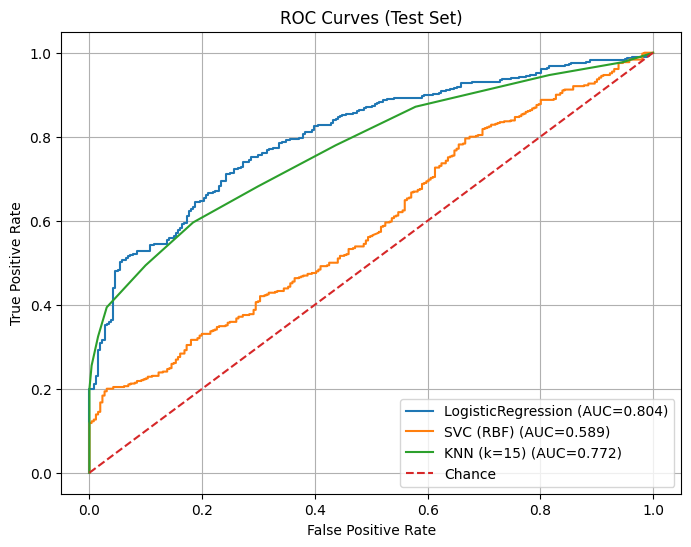

In [15]:
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], '--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


# **Confusion Matrix for trained models**

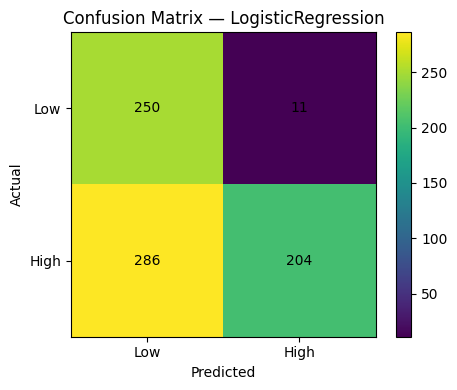

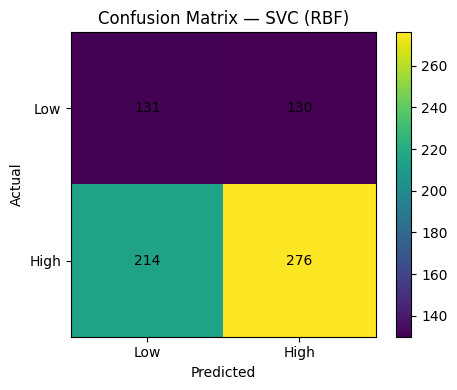

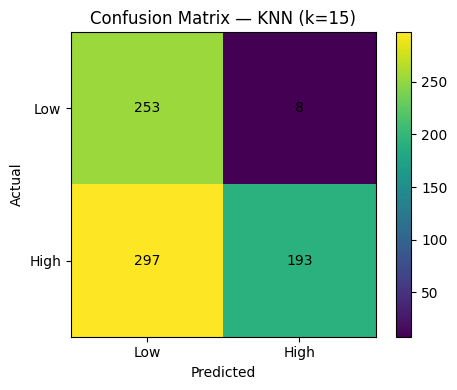

In [16]:
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Low', 'High']); ax.set_yticklabels(['Low', 'High'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()

for r in results:
    plot_cm(r['ConfusionMatrix'], f"Confusion Matrix — {r['Model']}")


## **Step 3: Feature Engineering**

Create log returns, rolling averages, and the target (volatility).

In [17]:
# Calculate daily log returns
# Flatten MultiIndex columns to single level for easier access
data.columns = data.columns.droplevel(1) # Drop the Ticker level (^GSPC)

data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data['Return'] = data['Close'].pct_change()

# Price-based features
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Price position relative to moving averages
data['Price_to_MA5'] = data['Close'] / data['MA_5']
data['Price_to_MA20'] = data['Close'] / data['MA_20']
data['MA5_to_MA20'] = data['MA_5'] / data['MA_20']

# Volatility features
data['Volatility_5'] = data['LogReturn'].rolling(window=5).std()
data['Volatility_10'] = data['LogReturn'].rolling(window=10).std()
data['Volatility_20'] = data['LogReturn'].rolling(window=20).std()

# Realized volatility as target (standard deviation of log returns over 10 days)
data['RealizedVolatility'] = data['LogReturn'].rolling(window=10).std()

# High-Low spread features
data['HL_Ratio'] = (data['High'] - data['Low']) / data['Close']
data['OC_Ratio'] = (data['Close'] - data['Open']) / data['Open']

# Volume features
data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()
data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_20']

# Momentum features
data['Momentum_5'] = data['Close'] / data['Close'].shift(5) - 1
data['Momentum_10'] = data['Close'] / data['Close'].shift(10) - 1

# RSI-like feature (simplified)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI_14'] = calculate_rsi(data['Close'], 14)

# Bollinger Bands
data['BB_Middle'] = data['Close'].rolling(window=20).mean()
bb_std = data['Close'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Middle'] + (bb_std * 2)
data['BB_Lower'] = data['BB_Middle'] - (bb_std * 2)
data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']
data['BB_Position'] = (data['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])

# Drop missing rows
data = data.dropna()

print(f"Total features created: {len([col for col in data.columns if col not in ['RealizedVolatility', 'VolHigh']])}")
data.head()

Total features created: 30


Price,Close,High,Low,Open,Volume,LogReturn,MA_5,MA_20,Volume_MA_5,RealizedVolatility,...,Volume_MA_20,Volume_Ratio,Momentum_5,Momentum_10,RSI_14,BB_Middle,BB_Upper,BB_Lower,BB_Width,BB_Position
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-13,1197.300049,1199.040039,1188.819946,1195.939941,5403580000,0.000685,1191.407983,1175.967987,4.870128e+09,0.004513,...,4.590326e+09,1.177167,0.006608,0.020525,68.753031,1175.967987,1200.407960,1151.528015,0.041566,0.936417
2010-04-14,1210.650024,1210.650024,1198.689941,1198.689941,5760040000,0.011088,1197.047998,1178.527490,5.001850e+09,0.005261,...,4.659839e+09,1.236103,0.023849,0.031860,81.303841,1178.527490,1206.196743,1150.858237,0.046956,1.080473
2010-04-15,1211.670044,1213.920044,1208.500000,1210.770020,5995330000,0.000842,1202.094019,1180.800494,5.255522e+09,0.004848,...,4.711446e+09,1.272503,0.021265,0.036120,83.979349,1180.800494,1211.511087,1150.089902,0.052017,1.002588
2010-04-16,1192.130005,1210.170044,1186.770020,1210.170044,8108470000,-0.016258,1201.646021,1182.115497,5.974902e+09,0.007697,...,4.905144e+09,1.653055,-0.001875,0.011909,64.800667,1182.115497,1212.376027,1151.854967,0.051197,0.665471
2010-04-19,1197.520020,1197.869995,1183.680054,1192.060059,6597740000,0.004511,1201.854028,1183.996497,6.373032e+09,0.007439,...,4.974410e+09,1.326336,0.000869,0.008489,64.287416,1183.996497,1213.097346,1154.895647,0.049157,0.732356


## **Step 4: Define Regression Features and Target**

Now that you have engineered features, define:

X (independent variables) → predictors

y (dependent variable) → realized volatility

In [18]:
# Feature columns - using all engineered features
feature_columns = [
    'LogReturn', 'Return',
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    'Price_to_MA5', 'Price_to_MA20', 'MA5_to_MA20',
    'Volatility_5', 'Volatility_10', 'Volatility_20',
    'HL_Ratio', 'OC_Ratio',
    'Volume', 'Volume_MA_5', 'Volume_MA_20', 'Volume_Ratio',
    'Momentum_5', 'Momentum_10',
    'RSI_14',
    'BB_Width', 'BB_Position'
]

# Target variable
target = 'RealizedVolatility'

X = data[feature_columns].copy()
y = data[target].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {len(feature_columns)}")
print(f"Feature names: {feature_columns}")


Feature matrix shape: (3705, 23)
Target shape: (3705,)

Features used: 23
Feature names: ['LogReturn', 'Return', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'Price_to_MA5', 'Price_to_MA20', 'MA5_to_MA20', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'HL_Ratio', 'OC_Ratio', 'Volume', 'Volume_MA_5', 'Volume_MA_20', 'Volume_Ratio', 'Momentum_5', 'Momentum_10', 'RSI_14', 'BB_Width', 'BB_Position']


# **EDA**

## **Visualize Volatility**

To understand the regression target visually:

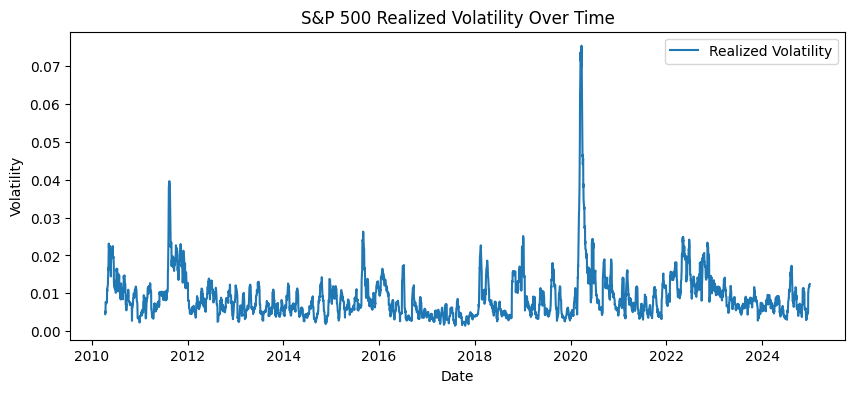

In [19]:
plt.figure(figsize=(10,4))
plt.plot(data.index, data['RealizedVolatility'], label='Realized Volatility')
plt.title('S&P 500 Realized Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## **Log Returns Analysis**

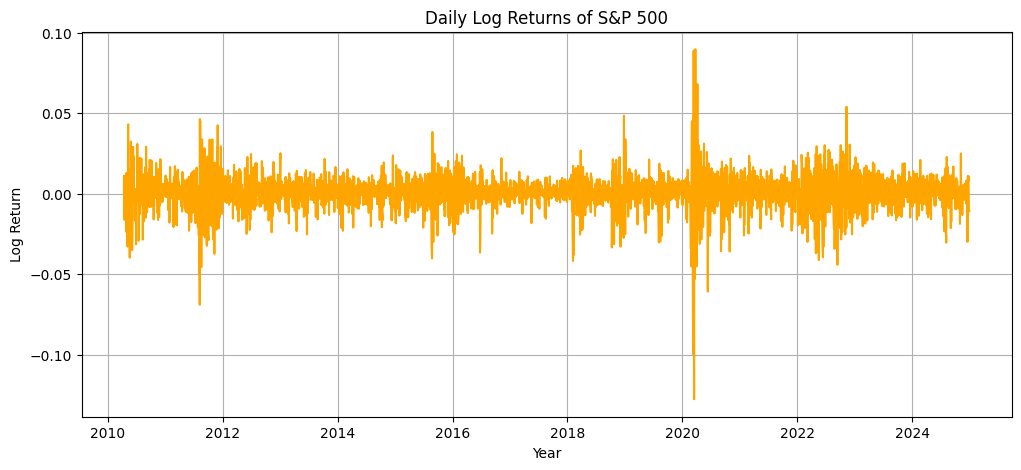

In [20]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['LogReturn'], color='orange')
plt.title('Daily Log Returns of S&P 500')
plt.xlabel('Year')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()


## **Distribution of Log Returns**

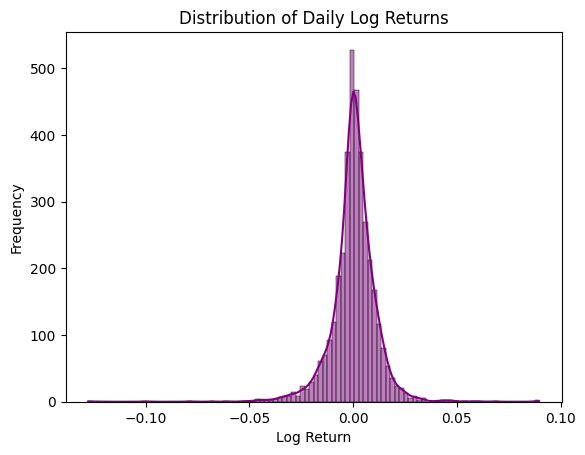

In [21]:
import seaborn as sns

sns.histplot(data['LogReturn'], bins=100, kde=True, color='purple')
plt.title('Distribution of Daily Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()


## **Volatility (Target Variable) Over Time**

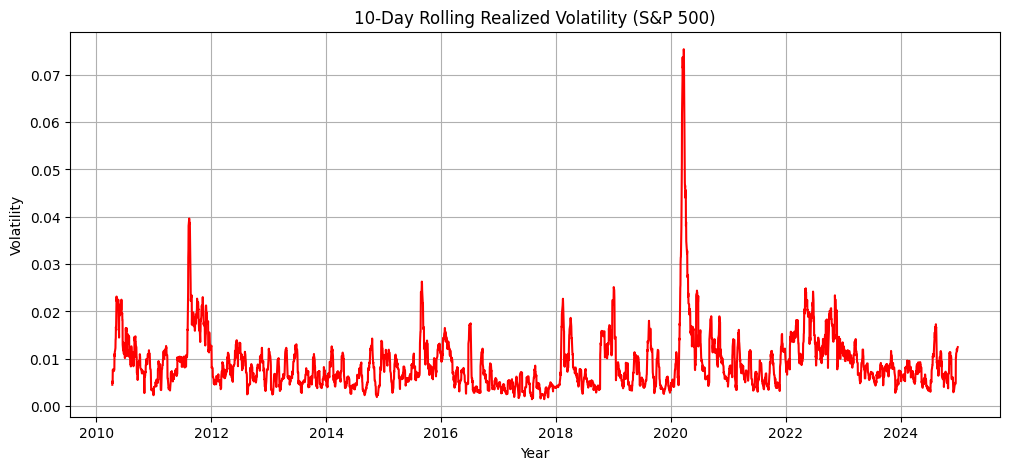

In [22]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['RealizedVolatility'], color='red')
plt.title('10-Day Rolling Realized Volatility (S&P 500)')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()


## **Price vs. Volatility Relationship**

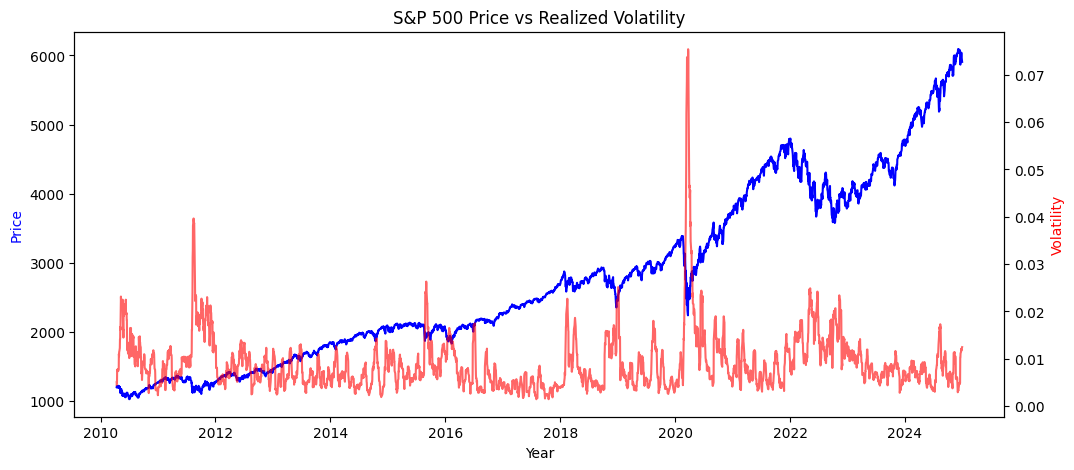

In [23]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(data.index, data['Close'], color='blue', label='Close')
ax2 = ax1.twinx()
ax2.plot(data.index, data['RealizedVolatility'], color='red', label='Volatility', alpha=0.6)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price', color='blue')
ax2.set_ylabel('Volatility', color='red')
plt.title('S&P 500 Price vs Realized Volatility')
plt.show()


# **Create a binary classification label from RealizedVolatility**

In [24]:
# Use median split (balanced) — change to quantile(0.7) for top-30%-as-high, etc.
threshold = data['RealizedVolatility'].median()
data['VolHigh'] = (data['RealizedVolatility'] >= threshold).astype(int)

# Use all engineered features for classification
X = data[feature_columns].copy()
y_cls = data['VolHigh'].copy()

print("Threshold used for High volatility:", threshold)
print("\nClass distribution:")
print(y_cls.value_counts(normalize=True).rename({0:'Low',1:'High'}).to_frame('share'))
print(f"\nTotal samples: {len(y_cls)}")
print(f"Features: {len(feature_columns)}")


Threshold used for High volatility: 0.007542860900912798

Class distribution:
            share
VolHigh          
High     0.500135
Low      0.499865

Total samples: 3705
Features: 23


# **Train Test Split**

In [25]:
split_idx = int(len(X) * 0.80)  # 80% train, 20% test chronologically
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y_cls.iloc[:split_idx], y_cls.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2964, 23) Test size: (741, 23)


In [26]:
X_train

Price,LogReturn,Return,MA_5,MA_10,MA_20,MA_50,Price_to_MA5,Price_to_MA20,MA5_to_MA20,Volatility_5,...,OC_Ratio,Volume,Volume_MA_5,Volume_MA_20,Volume_Ratio,Momentum_5,Momentum_10,RSI_14,BB_Width,BB_Position
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-13,0.000685,0.000685,1191.407983,1185.471985,1175.967987,1134.063589,1.004945,1.018140,1.013130,0.004620,...,0.001137,5403580000,4.870128e+09,4.590326e+09,1.177167,0.006608,0.020525,68.753031,0.041566,0.936417
2010-04-14,0.011088,0.011150,1197.047998,1189.209985,1178.527490,1136.492791,1.011363,1.027256,1.015715,0.004218,...,0.009978,5760040000,5.001850e+09,4.659839e+09,1.236103,0.023849,0.031860,81.303841,0.046956,1.080473
2010-04-15,0.000842,0.000843,1202.094019,1193.433984,1180.800494,1138.659792,1.007966,1.026143,1.018033,0.004557,...,0.000743,5995330000,5.255522e+09,4.711446e+09,1.272503,0.021265,0.036120,83.979349,0.052017,1.002588
2010-04-16,-0.016258,-0.016127,1201.646021,1194.836987,1182.115497,1140.556792,0.992081,1.008472,1.016522,0.009885,...,-0.014907,8108470000,5.974902e+09,4.905144e+09,1.653055,-0.001875,0.011909,64.800667,0.051197,0.665471
2010-04-19,0.004511,0.004521,1201.854028,1195.844995,1183.996497,1143.244993,0.996394,1.011422,1.015082,0.010108,...,0.004580,6597740000,6.373032e+09,4.974410e+09,1.326336,0.000869,0.008489,64.287416,0.049157,0.732356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-11,0.009118,0.009160,4691.403906,4738.508984,4711.773999,4678.144805,1.004618,1.000275,0.995677,0.010354,...,0.009409,4101590000,4.395630e+09,4.094478e+09,1.001737,-0.016787,-0.015310,58.403975,0.056548,0.504863
2022-01-12,0.002814,0.002818,4696.557910,4731.837988,4716.387012,4680.398408,1.006343,1.002112,0.995796,0.005113,...,-0.000474,4048220000,4.227682e+09,4.072618e+09,0.994009,0.005482,-0.013918,54.307788,0.054359,0.538861
2022-01-13,-0.014346,-0.014244,4689.153906,4719.867969,4713.845996,4680.966006,0.993576,0.988371,0.994762,0.008702,...,-0.015745,4251730000,4.218972e+09,4.039698e+09,1.052487,-0.007883,-0.025049,41.304085,0.055464,0.290337


# **Defining the models**
1. Logistic Regression
2. SVC
3. KNN


In [27]:
def pipe_scale(est):
    """Attach StandardScaler for models that benefit from feature scaling."""
    return Pipeline([('scaler', StandardScaler()), ('clf', est)])

models = {
    'LogisticRegression': pipe_scale(LogisticRegression(max_iter=2000, random_state=42)),
    'SVC (RBF)':         pipe_scale(SVC(kernel='rbf', probability=True, random_state=42)),
    'KNN (k=15)':        pipe_scale(KNeighborsClassifier()),

}

# **Model Training and Calculating Evalution Metrics**

In [28]:
results = []
roc_curves = {}  # model -> (fpr, tpr, auc)

for name, est in models.items():
    # Train timing
    t0 = time.perf_counter()
    est.fit(X_train, y_train)
    train_time = time.perf_counter() - t0

    # Inference timing
    t1 = time.perf_counter()
    y_pred = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_score = est.predict_proba(X_test)[:, 1]
    elif hasattr(est, "decision_function"):
        y_score = est.decision_function(X_test)
    else:
        y_score = y_pred.astype(float)
    test_time = time.perf_counter() - t1

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_test, y_score)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1,
        'ROC_AUC': auc, 'TrainTime_s': train_time, 'TestTime_s': test_time,
        'ConfusionMatrix': cm
    })

    # ROC curve data
    try:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_curves[name] = (fpr, tpr, auc)
    except ValueError:
        pass

# Summary table
summary_df = pd.DataFrame(results).drop(columns=['ConfusionMatrix']).sort_values('ROC_AUC', ascending=False)
print("=== Test-set performance (sorted by ROC_AUC) ===")
print(summary_df.to_string(index=False))

# Classification reports
print("\n=== Classification reports ===")
for r in results:
    name = r['Model']
    est = models[name]
    y_pred = est.predict(X_test)
    print(f"\n[{name}]")
    print(classification_report(y_test, y_pred, digits=4))

=== Test-set performance (sorted by ROC_AUC) ===
             Model  Accuracy  Precision   Recall       F1  ROC_AUC  TrainTime_s  TestTime_s
LogisticRegression  0.982456   0.997877 0.975104 0.986359 0.999231     0.024515    0.005736
         SVC (RBF)  0.879892   0.898580 0.919087 0.908718 0.956956     0.739925    0.078768
        KNN (k=15)  0.819163   0.926471 0.784232 0.849438 0.883906     0.004964    0.086070

=== Classification reports ===

[LogisticRegression]
              precision    recall  f1-score   support

           0     0.9556    0.9961    0.9754       259
           1     0.9979    0.9751    0.9864       482

    accuracy                         0.9825       741
   macro avg     0.9767    0.9856    0.9809       741
weighted avg     0.9831    0.9825    0.9825       741


[SVC (RBF)]
              precision    recall  f1-score   support

           0     0.8427    0.8069    0.8245       259
           1     0.8986    0.9191    0.9087       482

    accuracy             

# **Combined ROC Curve**

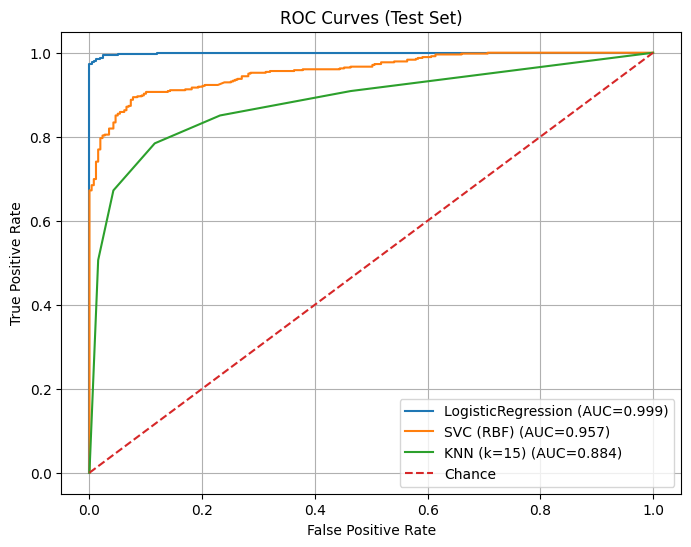

In [29]:
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], '--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


# **Individual ROC curve for trained models**

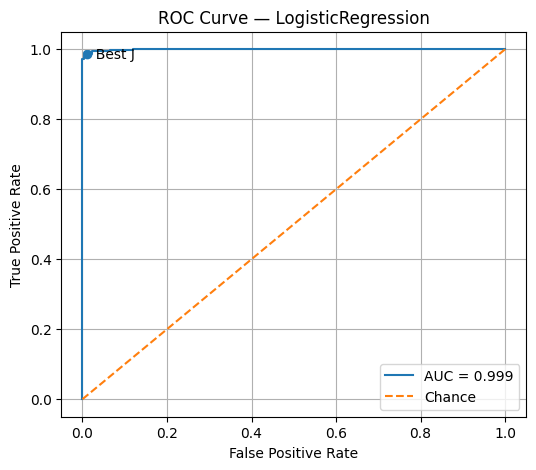

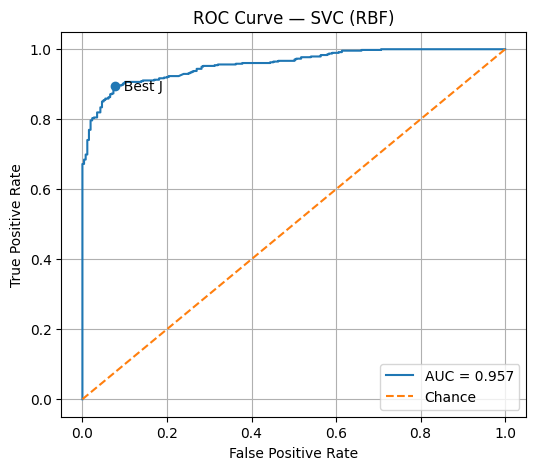

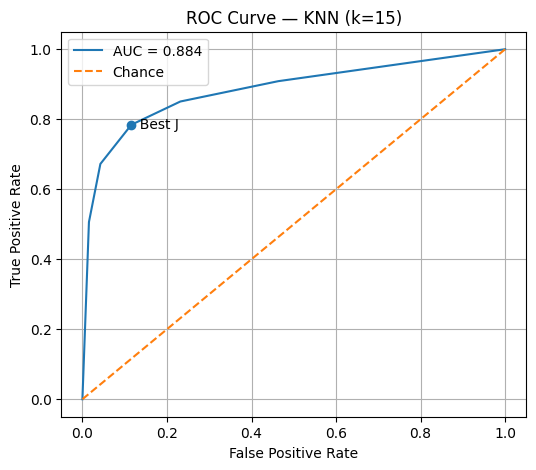

In [30]:

def plot_individual_roc_from_cache(roc_curves_dict):
    for name, (fpr, tpr, auc) in roc_curves_dict.items():
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1], [0,1], '--', label="Chance")
        # Mark best Youden J point (optional)
        youden_idx = np.argmax(tpr - fpr)
        plt.scatter(fpr[youden_idx], tpr[youden_idx], marker='o')
        plt.text(fpr[youden_idx], tpr[youden_idx], "  Best J", va='center')

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_individual_roc_from_cache(roc_curves)


# **Confusion Matrix for trained models**

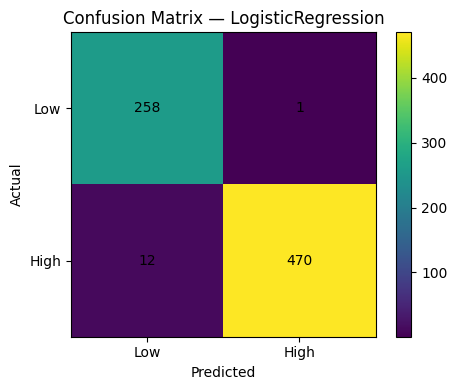

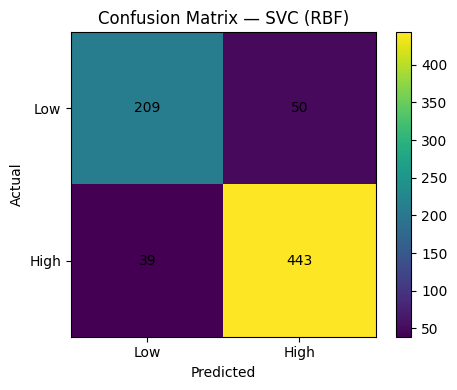

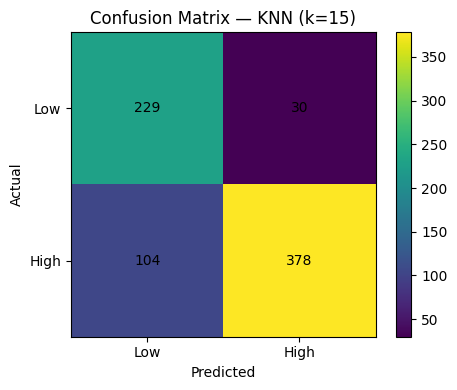

In [31]:
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Low', 'High']); ax.set_yticklabels(['Low', 'High'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()

for r in results:
    plot_cm(r['ConfusionMatrix'], f"Confusion Matrix — {r['Model']}")


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 1. Setup the "Best" Models
# (Replace these parameter values with the specific output from your GridSearchCV)
best_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ]),

    'SVC (Tuned)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ]),

    'KNN (Tuned)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ])
}

# 2. Setup Cross-Validation Strategy
# 10-fold is standard for robust estimation. Stratified ensures class balance in every fold.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

print("=== Cross-Validation Performance (10-Fold) ===\n")

for name, model in best_models.items():
    # Run Cross-Validation
    # This splits X_train into 10 parts: trains on 9, tests on 1, repeats 10 times.
    scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)

    # Calculate Mean and Standard Deviation
    mean_score = np.mean(scores)
    std_dev = np.std(scores)

    cv_results.append({
        'Model': name,
        'Mean Accuracy': mean_score,
        'Std Dev': std_dev,
        'Min Score': np.min(scores),
        'Max Score': np.max(scores)
    })

    print(f"[{name}]")
    print(f"  Accuracy: {mean_score:.4f} (+/- {std_dev:.4f})")
    print(f"  Range:    {np.min(scores):.4f} - {np.max(scores):.4f}\n")

# 3. Summary Table
cv_df = pd.DataFrame(cv_results).sort_values('Mean Accuracy', ascending=False)
print("=== CV Summary Table ===")
print(cv_df.to_string(index=False))

=== Cross-Validation Performance (10-Fold) ===

[LogisticRegression]
  Accuracy: 0.9791 (+/- 0.0084)
  Range:    0.9629 - 0.9865

[SVC (Tuned)]
  Accuracy: 0.9538 (+/- 0.0146)
  Range:    0.9275 - 0.9713

[KNN (Tuned)]
  Accuracy: 0.9001 (+/- 0.0116)
  Range:    0.8870 - 0.9172

=== CV Summary Table ===
             Model  Mean Accuracy  Std Dev  Min Score  Max Score
LogisticRegression       0.979084 0.008368   0.962901   0.986509
       SVC (Tuned)       0.953778 0.014570   0.927487   0.971332
       KNN (Tuned)       0.900141 0.011613   0.887015   0.917230
